In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu May 20 01:50:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:18:00.0 Off |                  Off |
| 39%   64C    P2   258W / 260W |  32830MiB / 48601MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:3B:00.0 Off |                  Off |
| 33%   

## Setup imports

In [2]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    RandGaussianNoised,
    Spacingd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Oct  8 2020, 12:12:24)  [GCC 8.4.0]
OS version: Linux (4.15.0-130-generic)
Numpy version: 1.19.4
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.0
Tensorboard version: 2.4.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.56.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [3]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [10]:
train_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/*/*.npy'))
train_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/*/*.npy'))

valid_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise100_b50f_5.0/*/*.npy'))
valid_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise100_b50f_5.0/*/*.npy'))

total_low_list  = train_low_images  + valid_low_images
total_high_list = train_high_images + valid_high_images

train_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(total_low_list, total_high_list)]

## Augmentation

In [49]:
# CT에 맞는 Augmentation
from torchvision import transforms
train_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
#         RandGaussianNoised(keys=["low"], prob=1.0, mean=0.0, std=(0.25, 1.00)),
        RandGaussianNoised(keys=["low"], prob=1.0, mean=0.0, std=(0.01, )),
    ]
)

Noise =  0.001


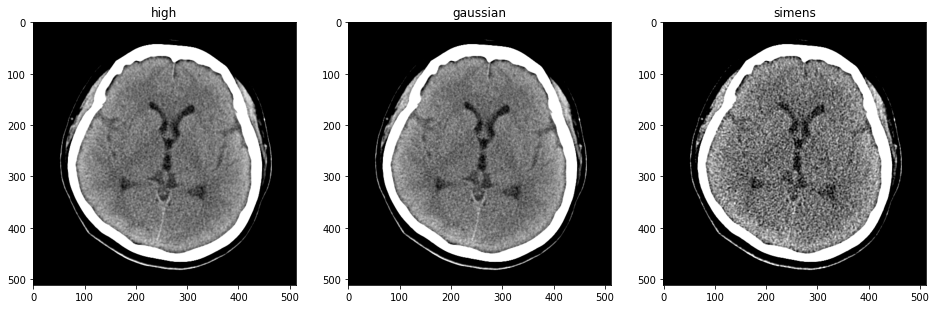

Noise =  0.002


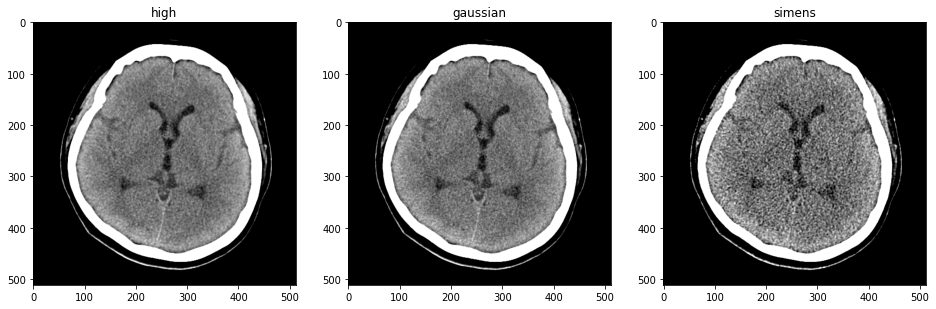

Noise =  0.003


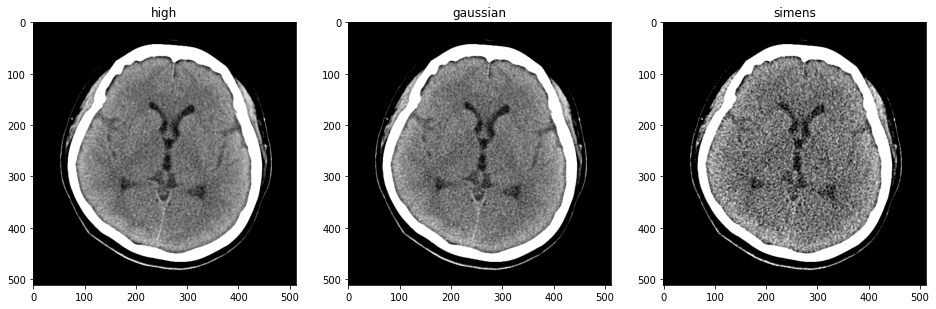

Noise =  0.004


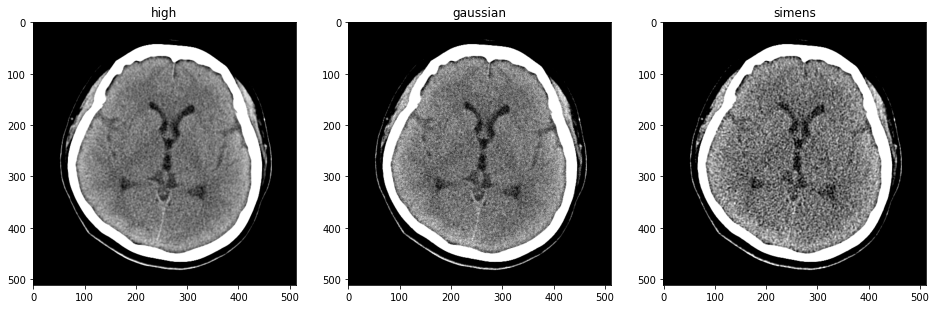

Noise =  0.005


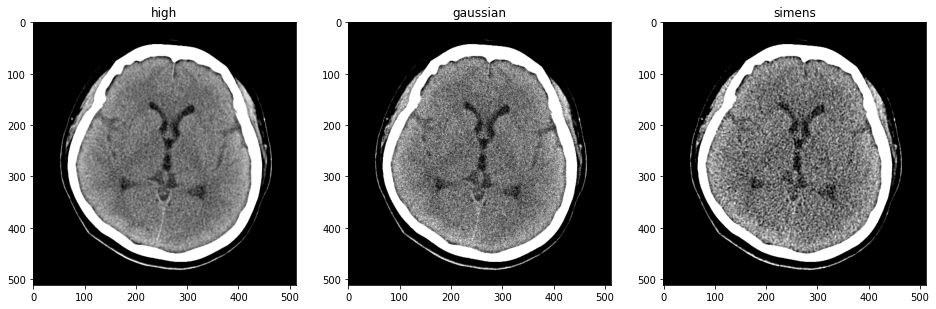

Noise =  0.006


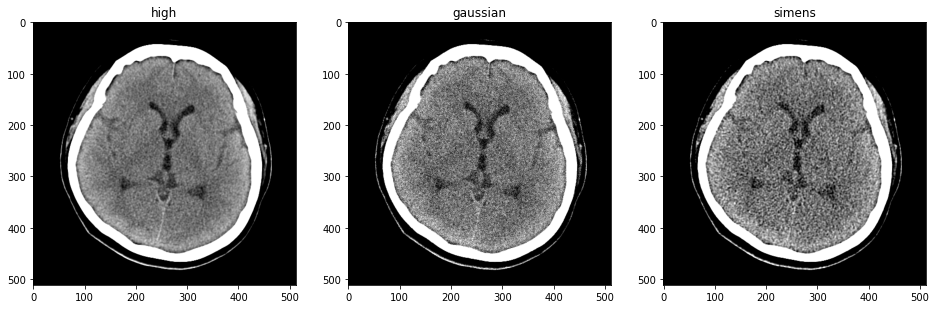

Noise =  0.007


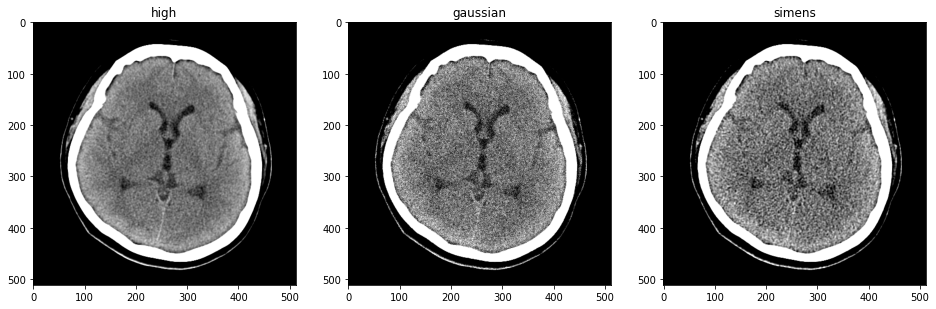

Noise =  0.008


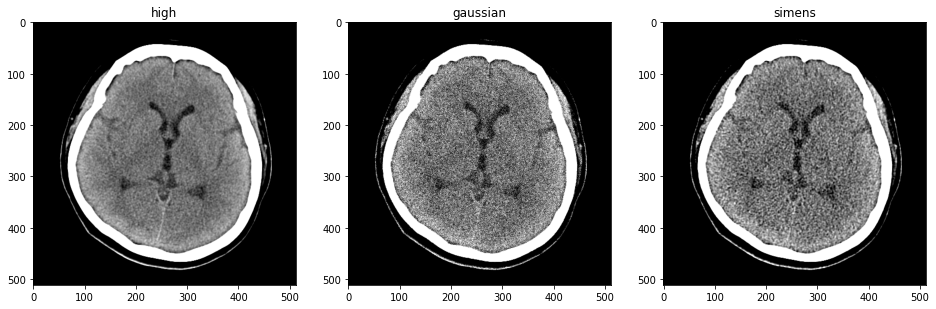

Noise =  0.009000000000000001


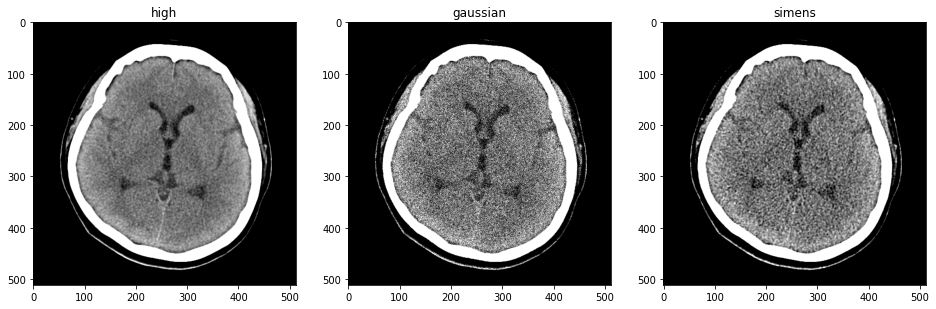

Noise =  0.010000000000000002


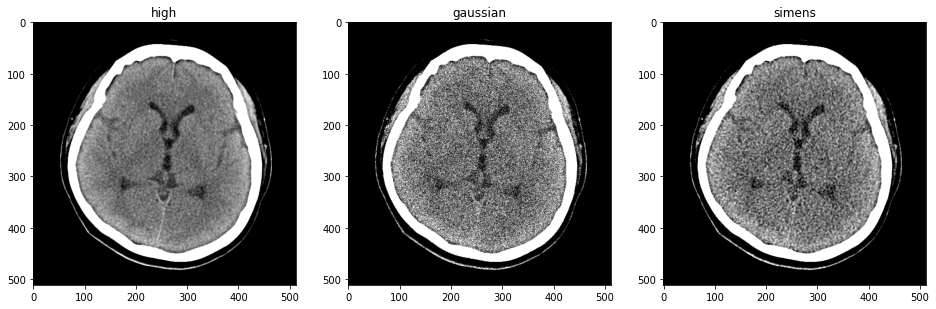

Noise =  0.011


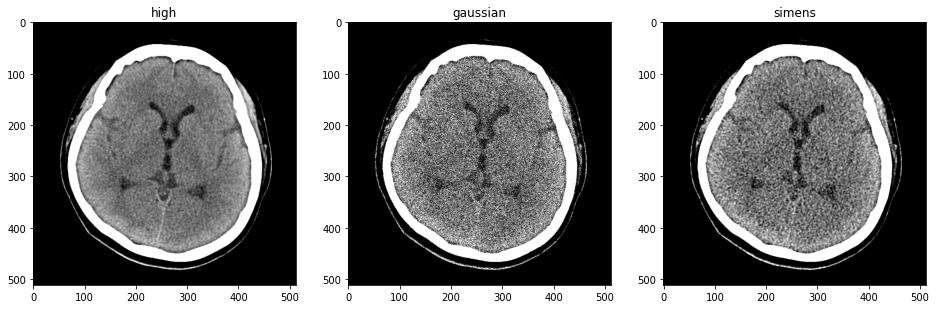

Noise =  0.012


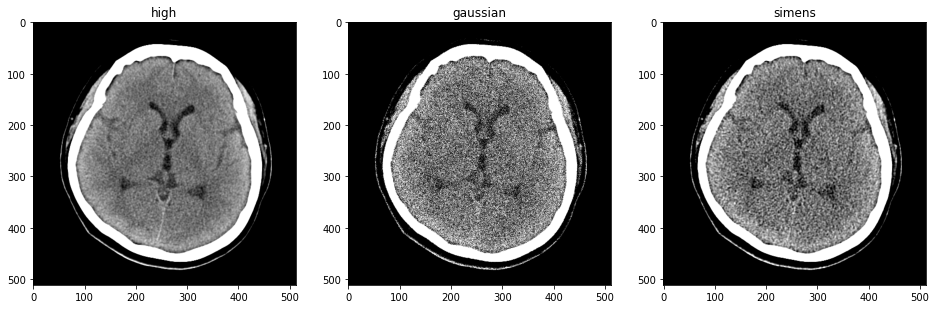

Noise =  0.013000000000000001


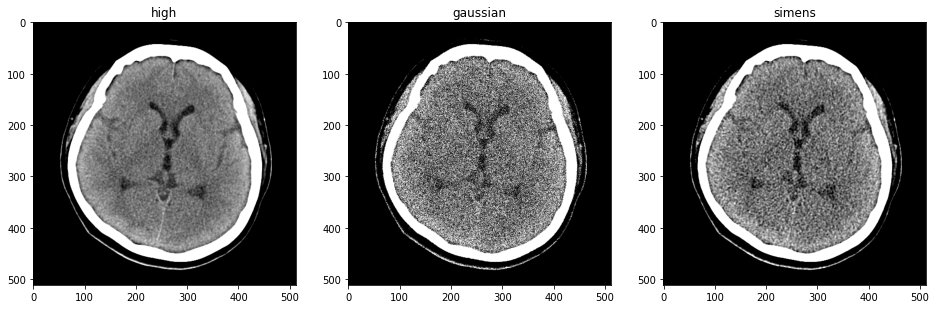

Noise =  0.014000000000000002


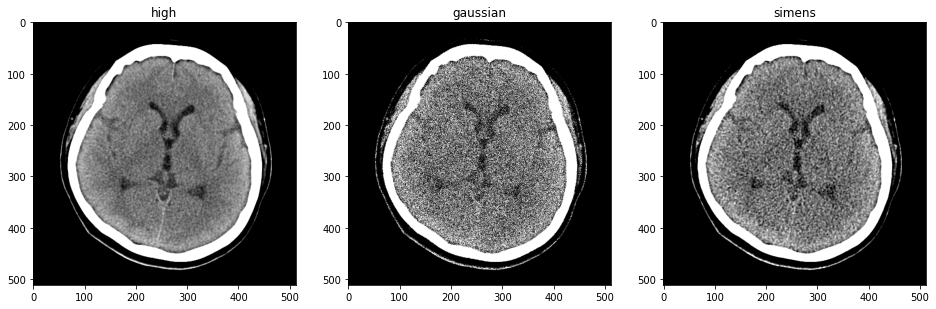

Noise =  0.015


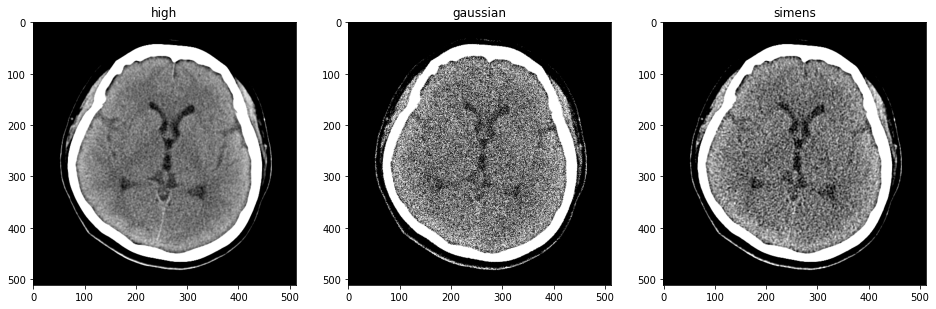

Noise =  0.016


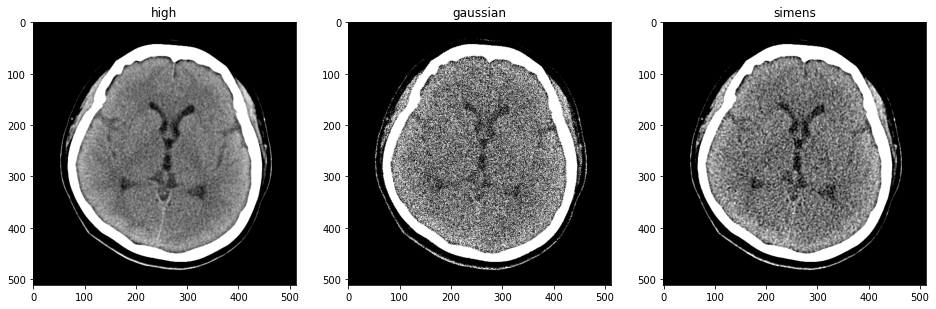

Noise =  0.017


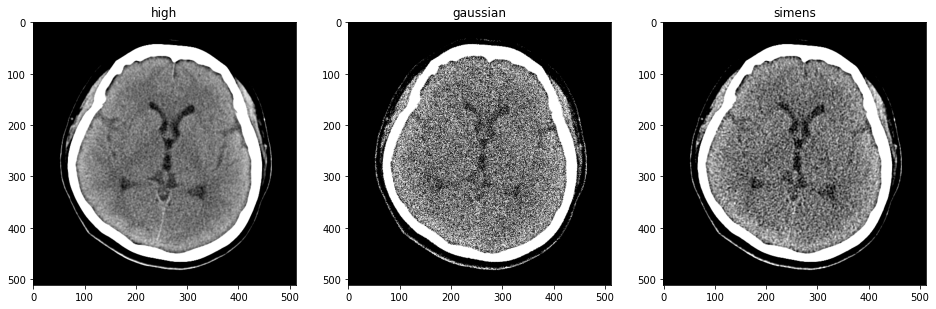

Noise =  0.018000000000000002


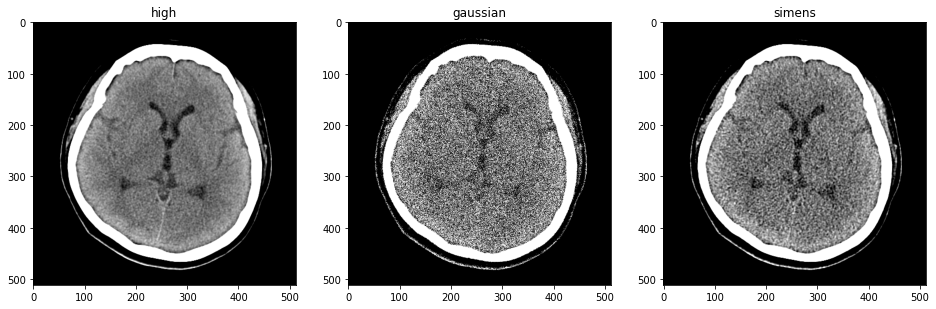

Noise =  0.019000000000000003


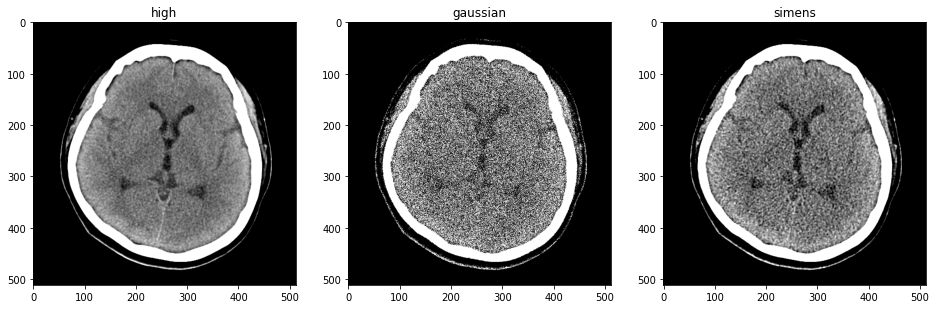

Noise =  0.02


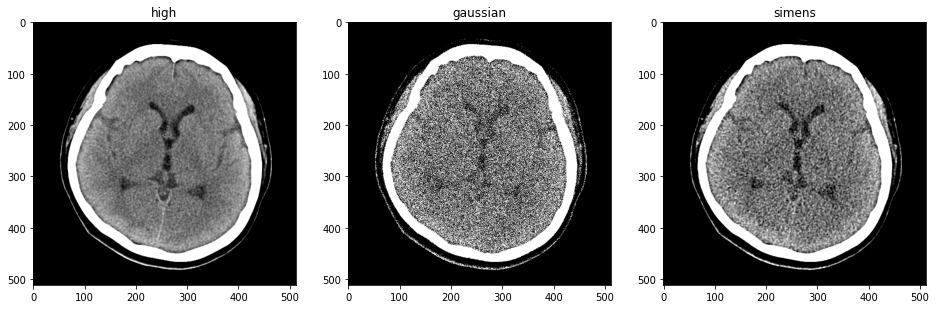

Noise =  0.021


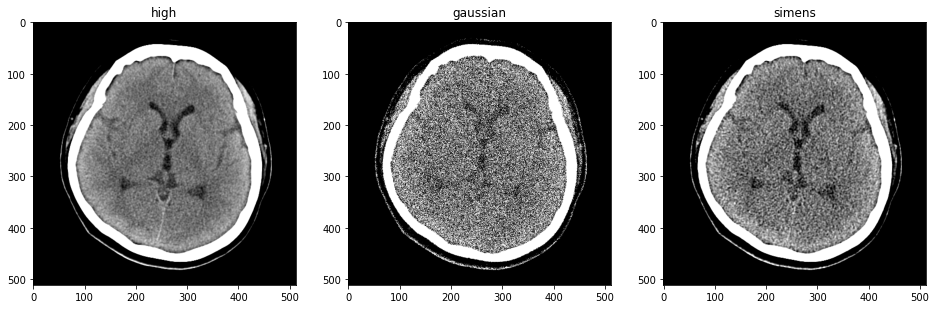

Noise =  0.022000000000000002


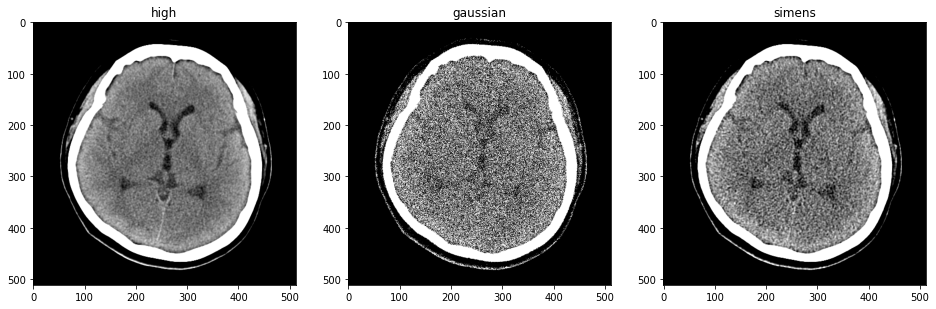

Noise =  0.023


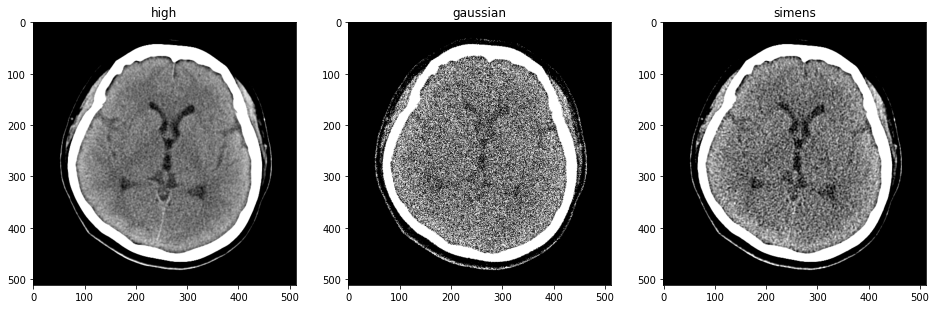

Noise =  0.024


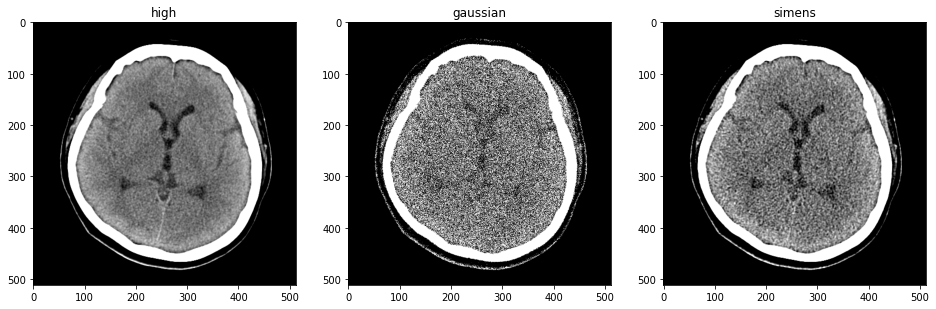

Noise =  0.025


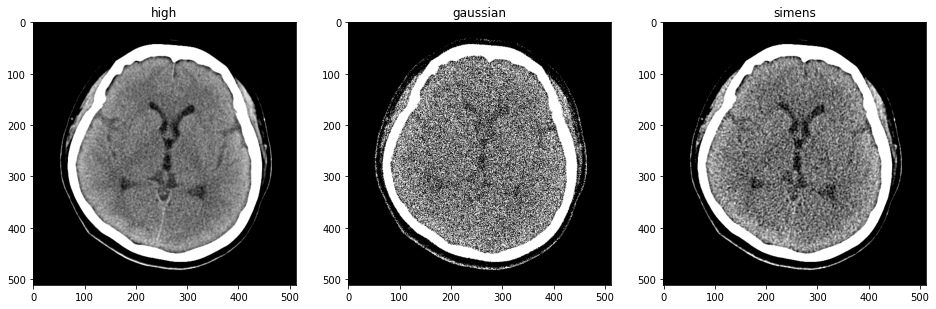

Noise =  0.026000000000000002


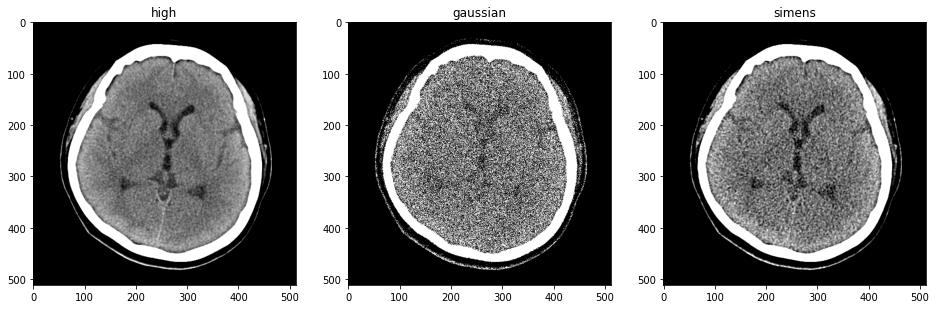

Noise =  0.027000000000000003


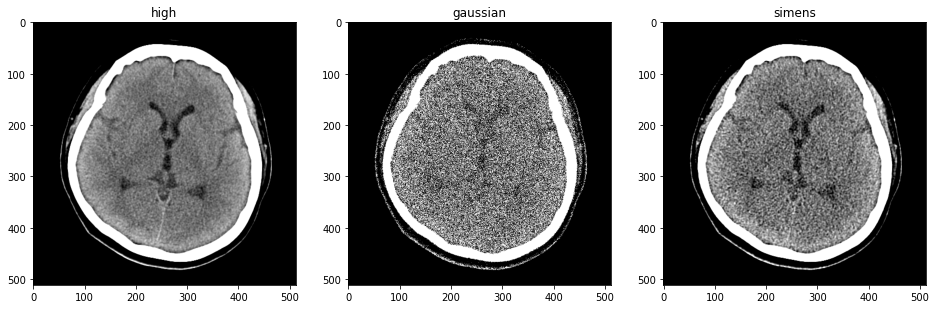

Noise =  0.028


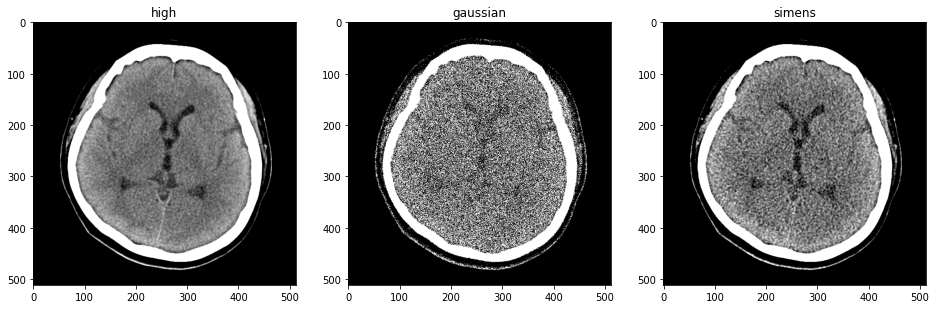

Noise =  0.029


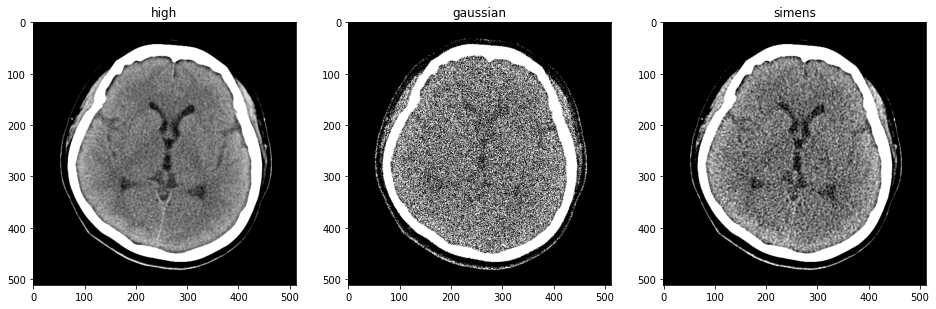

Noise =  0.03


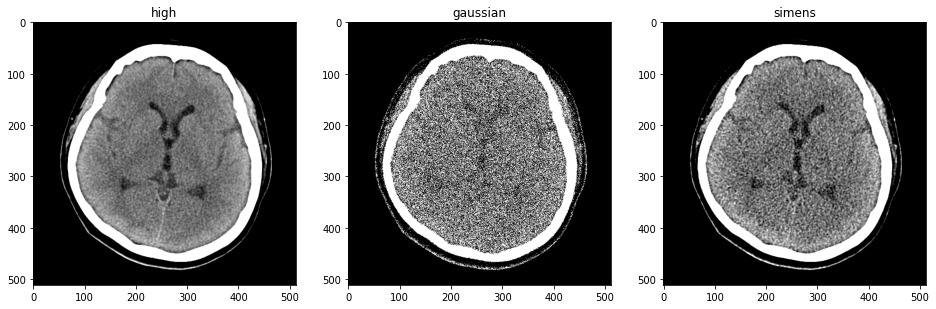

In [65]:
sample  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise20_b50f_5.0/*/*.npy'))
sample_img = np.load(sample[184])
sample_img -= 0.5
sample_img /= 0.5


for k in (np.linspace(0.001, 0.03, 30)).tolist():
    train_transforms = Compose(
        [
            LoadNumpyd(keys=["low", "high"]),
            AddChanneld(keys=["low", "high"]), 
            ToTensord(keys=["low", "high"]),
            Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
            RandGaussianNoised(keys=["low"], prob=1.0, mean=0.0, std=(k, k)),
        ]
    )
    check_ds = Dataset(data=train_files, transform=train_transforms)
    check_data = check_ds[184]
    
    print("Noise = ", k)
    
    low = (check_data["low"][0])
    high = (check_data["high"][0])

    plt.figure("check", (16, 10))
    plt.subplot(1, 3, 1)
    plt.title("high")
    plt.imshow(visual_windowing(high), cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("gaussian")
    plt.imshow(visual_windowing(low), cmap="gray")
    
    plt.subplot(1, 3, 3)
    plt.title("simens")
    plt.imshow(visual_windowing(sample_img), 'gray')

    plt.show()

## Check transforms in DataLoader

In [20]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/HUH_JEO_F79/HUH_JEO_F79_001_20210218_184251_00026.npy
/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/HUH_JEO_F79/HUH_JEO_F79_001_20210218_184251_00026.npy
image shape: torch.Size([512, 512])


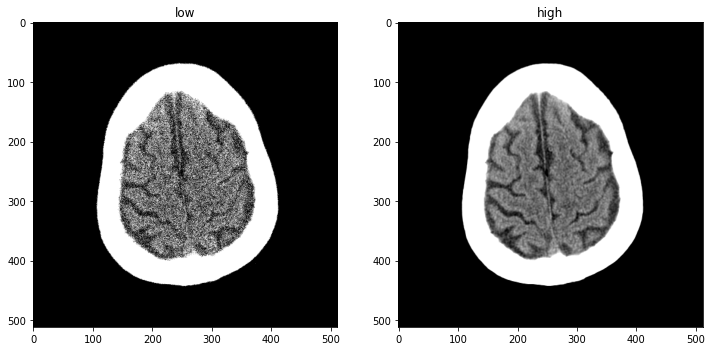

In [21]:
check_ds = Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[160]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

## DataLoader

In [8]:
import multiprocessing
# from torchsampler.imbalanced import ImbalancedDatasetSampler, sunggu_ImbalancedDatasetSampler

# cf) use batch_size=2 to load images and use RandCropByPosNegLabeld
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=8, drop_last=True)

CPU 갯수 =  48


## Create Model, Loss, Optimizer  Only Low -> High

In [9]:
from Unet_sunggu.model import UNet

device = 'cuda'
model = UNet()      
model.to(device)

UNet(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## 모델 이어서 학습하기

In [ ]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/Unet_with_perceptual/epoch_910_model.pth'
checkpoint = torch.load(checkpoint_dir)
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])

## multi-gpu 사용
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to('cuda')  

print(epoch)

## 손실함수 정의하기

In [ ]:
from torchvision import models
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)        
        h_relu3 = self.slice3(h_relu2)        
        h_relu4 = self.slice4(h_relu3)        
        h_relu5 = self.slice5(h_relu4)                
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out

    
class VGGLoss(torch.nn.Module):
    def __init__(self, device):
        super(VGGLoss, self).__init__()        
        self.vgg = Vgg19().to(device)
        self.criterion = torch.nn.L1Loss()
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]        

    def forward(self, x, y):              
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())        
        return loss

In [ ]:
# define loss functions
L1_loss            = torch.nn.L1Loss()
Perceptual_loss    = VGGLoss(device='cuda')

learning_rate = 2e-4
max_epochs = 1000

# Optimizer 설정하기
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

def lambda_rule(epoch, start_decay_epoch=50, total_epoch=max_epochs):
    lr = 1.0 - max(0, epoch - start_decay_epoch) / float(total_epoch)
    return lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

In [ ]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler.load_state_dict(checkpoint['scheduler'])        

In [ ]:
print(checkpoint['epoch'])

## Train

In [ ]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy        = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm         = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
epoch_num = max_epochs
val_interval = 5

best_metric = -1
best_metric_epoch = -1

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/Unet_with_perceptual')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/Unet_with_perceptual/'

low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'Unet_with_perceptual'+'/low2high/'

# 모델 save폴더 만들기
os.makedirs(root_dir, mode=0o777, exist_ok=True)
os.makedirs(low2high_png_dir, mode=0o777, exist_ok=True)

for epoch in range(911, epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    model.train()    
    
    # Loss 선언    
    loss_total_train = []
    loss_fm_train    = []
    loss_vgg_train   = []    
        
    train_iterator = tqdm(train_loader, desc='Train', file=sys.stdout)    
    for batch_data in train_iterator:
        
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Generate fake
        output = model(input_low)    

        optimizer.zero_grad()

        # Loss 
        loss1 = L1_loss(output, input_high)
        loss2 = Perceptual_loss(output.repeat(1,3,1,1), input_high.repeat(1,3,1,1)) * 10

        loss     = loss1 + loss2
        
        loss.backward()
        optimizer.step()
        
        # 기록        
        loss_total_train  += [loss.item()]
        loss_fm_train     += [loss1.item()]
        loss_vgg_train    += [loss2.item()]

        
    print( "Loss       [Total Loss]    = %.4f" %np.mean(loss_total_train) ) 
    print( "Loss       [FM    Loss]    = %.4f" %np.mean(loss_fm_train) ) 
    print( "Loss       [VGG   Loss]    = %.4f" %np.mean(loss_vgg_train) ) 
    
    # Tensorboard 저장하기
    input_low   = fn_denorm_window(fn_tonumpy((input_low)))
    input_high  = fn_denorm_window(fn_tonumpy((input_high)))
    output      = fn_denorm_window(fn_tonumpy((output)))

    input_low   = np.clip(input_low, a_min=0, a_max=1)
    input_high  = np.clip(input_high, a_min=0, a_max=1)
    output      = np.clip(output, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(),      cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
    # Loss Write    
    writer.add_scalar('Train/loss_total',  np.mean(loss_total_train), epoch)
    writer.add_scalar('Train/loss_fm',   np.mean(loss_fm_train), epoch)
    writer.add_scalar('Train/loss_vgg',  np.mean(loss_vgg_train), epoch)
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'model_state_dict': model.module.state_dict(), 
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'model_state_dict': model.state_dict(), 
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                         }                         

            torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
        
    # Scheduler
    writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
    old_lr = optimizer.param_groups[0]['lr']
    lr     = optimizer.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))
    scheduler.step()     
    
writer.close()    

## TEST

In [ ]:
#     with torch.no_grad():
#         netG.eval()
#         netD.eval()

#         loss_G_gan_valid  = []
#         loss_G_L1_valid   = []
#         loss_D_real_valid = []
#         loss_D_fake_valid = []
        
#         valid_iterator = tqdm(valid_loader, desc='Valid', file=sys.stdout)    
#         for batch_data in valid_iterator:
        
#             input_low  = batch_data['low'].to(device)
#             input_high = batch_data['high'].to(device)
            
#             output = netG(input_low)

#             real = torch.cat([input_low, input_high], dim=1)
#             fake = torch.cat([input_low, output], dim=1)      
            
#             # D
#             pred_real = netD(real)        
#             pred_fake = netD(fake.detach())

#             loss_D_real = gan_loss(pred_real, torch.ones_like(pred_real))
#             loss_D_fake = gan_loss(pred_fake, torch.zeros_like(pred_fake))

#             # G
#             pred_fake = netD(fake)        
            
#             loss_G_gan = gan_loss(pred_fake, torch.ones_like(pred_fake))
#             loss_G_L1  = L1_loss(output, input_high)

#             # 기록
#             loss_D_real_valid += [loss_D_real.item()]
#             loss_D_fake_valid += [loss_D_fake.item()]
#             loss_G_gan_valid  += [loss_G_gan.item()]
#             loss_G_L1_valid   += [loss_G_L1.item()]
        
        
#     print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_valid) ) 
#     print( "Generator Loss       [L1  Loss]    = %.4f" %np.mean(loss_G_L1_valid) ) 
#     print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_valid) )
#     print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_valid) )

    
#     # Tensorboard 저장하기
#     input_low   = fn_denorm(fn_tonumpy((input_low)))
#     input_high  = fn_denorm(fn_tonumpy((input_high)))
#     output = fn_denorm(fn_tonumpy((output)))

#     input_low   = np.clip(input_low, a_min=0, a_max=1)
#     input_high  = np.clip(input_high, a_min=0, a_max=1)
#     output = np.clip(output, a_min=0, a_max=1)

#     # png Save
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(), cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
#     # Loss Write    
#     writer.add_scalar('Valid/loss_G_gan',  np.mean(loss_G_gan_valid), epoch)
#     writer.add_scalar('Valid/loss_G_L1',   np.mean(loss_G_L1_valid), epoch)
#     writer.add_scalar('Valid/loss_D_real', np.mean(loss_D_real_valid), epoch)
#     writer.add_scalar('Valid/loss_D_fake', np.mean(loss_D_fake_valid), epoch)

    
#     # 저장
#     if epoch % 5 == 0 or epoch == epoch_num:

#         if torch.cuda.device_count() > 1:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.module.state_dict(), 
#                           'netD_state_dict': netD.module.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),  
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                    

#         else:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.state_dict(), 
#                           'netD_state_dict': netD.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                         

#             torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
#     # Scheduler
#     writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
#     old_lr = optimizer_G.param_groups[0]['lr']
#     lr = optimizer_G.param_groups[0]['lr']
#     print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

#     scheduler_G.step()    
#     scheduler_D.step()    

# writer.close()

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)